In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import xgboost
import pydot

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.cluster import KMeans 
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from IPython.display import Image
from six import StringIO
from sklearn.tree import export_graphviz
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

%matplotlib inline

def classification_metrics(Y_pred, Y_true):
    acc = accuracy_score(Y_true, Y_pred)
    precision = precision_score(Y_true, Y_pred)
    recall = recall_score(Y_true, Y_pred)
    f1score = f1_score(Y_true, Y_pred)
    auc = roc_auc_score(Y_true, Y_pred)

    return acc, precision, recall, f1score, auc

def display_metrics(classifierName,Y_pred,Y_true):
    print ("______________________________________________")
    print ("Model: "+classifierName)
    acc, precision, recall, f1score, auc = classification_metrics(Y_pred,Y_true)
    print ("Accuracy: "+str(acc))
    print ("Precision: "+str(precision))
    print ("Recall: "+str(recall))
    print ("F1-score: "+str(f1score))
    print ("AUC: "+str(auc))
    print ("______________________________________________")
    print ("")

In [2]:
df = pd.concat(
    [
        pd.read_csv('customer_churn_dataset-training-master.csv'), 
        pd.read_csv('customer_churn_dataset-testing-master.csv')
    ], 
    axis=0)
df.reset_index(drop=True, inplace=True)

In [3]:
df.drop(columns='CustomerID', inplace=True)
df.columns = [col.replace(' ', '_') for col in df.columns]
df.dropna(inplace=True)
df = df.reset_index(drop = True)

In [4]:
age_bins = [0, 20, 30, 40, 50, 60, float('inf')]
age_labels = ['0-20', '21-30', '31-40', '41-50', '51-60', '61+']
df['Age_Group'] = pd.cut(df['Age'], bins=age_bins, labels=age_labels, right=False)
df.drop(columns='Age', inplace=True)

df

,Gender,Tenure,Usage_Frequency,Support_Calls,Payment_Delay,Subscription_Type,Contract_Length,Total_Spend,Last_Interaction,Churn,Age_Group
0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.0,17.0,1.0,31-40
1,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.0,6.0,1.0,61+
2,Female,14.0,4.0,6.0,18.0,Basic,Quarterly,185.0,3.0,1.0,51-60
3,Male,38.0,21.0,7.0,7.0,Standard,Monthly,396.0,29.0,1.0,51-60
4,Male,32.0,20.0,5.0,8.0,Basic,Monthly,617.0,20.0,1.0,21-30
...,...,...,...,...,...,...,...,...,...,...,...
505201,Female,33.0,12.0,6.0,21.0,Basic,Quarterly,947.0,14.0,1.0,41-50
505202,Male,6.0,1.0,5.0,22.0,Standard,Annual,923.0,9.0,1.0,31-40
505203,Male,39.0,14.0,8.0,30.0,Premium,Monthly,327.0,20.0,1.0,21-30
505204,Female,18.0,19.0,7.0,22.0,Standard,Monthly,540.0,13.0,1.0,51-60


# Building models

In [5]:
cat_feats = ['Gender'] 
df2 = pd.get_dummies(df, columns=cat_feats, drop_first = True)

encoder = LabelEncoder()
columns_to_encode = df2[['Age_Group', 'Subscription_Type', 'Contract_Length']]
for column in columns_to_encode:
    df2[column] = encoder.fit_transform(df2[column])

df2

,Tenure,Usage_Frequency,Support_Calls,Payment_Delay,Subscription_Type,Contract_Length,Total_Spend,Last_Interaction,Churn,Age_Group,Gender_Male
0,39.0,14.0,5.0,18.0,2,0,932.0,17.0,1.0,2,0
1,49.0,1.0,10.0,8.0,0,1,557.0,6.0,1.0,5,0
2,14.0,4.0,6.0,18.0,0,2,185.0,3.0,1.0,4,0
3,38.0,21.0,7.0,7.0,2,1,396.0,29.0,1.0,4,1
4,32.0,20.0,5.0,8.0,0,1,617.0,20.0,1.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...
505201,33.0,12.0,6.0,21.0,0,2,947.0,14.0,1.0,3,0
505202,6.0,1.0,5.0,22.0,2,0,923.0,9.0,1.0,2,1
505203,39.0,14.0,8.0,30.0,1,1,327.0,20.0,1.0,1,1
505204,18.0,19.0,7.0,22.0,2,1,540.0,13.0,1.0,4,0


In [6]:
features = df2.drop('Churn', axis=1)

X = features
y = df2['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)

# Decision Tree

Feature ranking:


<Axes: title={'center': 'Feature importances_Decision Tree'}, xlabel='Total Reduction of Criterion', ylabel='Feature'>

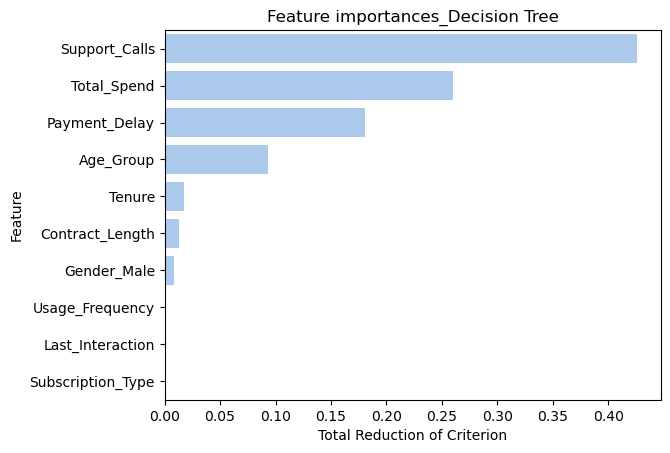

In [7]:
model_dt = DecisionTreeClassifier(criterion='entropy', random_state=101, max_depth=5)
model_dt.fit(X_train, y_train)

importances = model_dt.feature_importances_ 
indices = np.argsort(importances)[::-1]
print("Feature ranking:")

feature_names = X_train.columns 
fi = pd.DataFrame([feature_names[indices[0:10]], importances[indices][0:10]])
fi = fi.T
fi.columns = ['Feature', 'Total Reduction of Criterion']

plt.figure()
plt.title("Feature importances_Decision Tree")
sns.set_color_codes("pastel")
sns.barplot(x="Total Reduction of Criterion", y="Feature", data=fi, color="b")

In [8]:
y_pred = model_dt.predict(X_test)

confusion_matrix_results = confusion_matrix(y_test, y_pred)
print('confusion matrix: \n', confusion_matrix_results)
display_metrics('Decision Tree', y_pred, y_test)

confusion matrix: 
 [[56021 11271]
 [ 5838 78432]]
______________________________________________
Model: Decision Tree
Accuracy: 0.8871155038861984
Precision: 0.8743520283602555
Recall: 0.9307226771092916
F1-score: 0.9016571536962633
AUC: 0.8816143849791837
______________________________________________



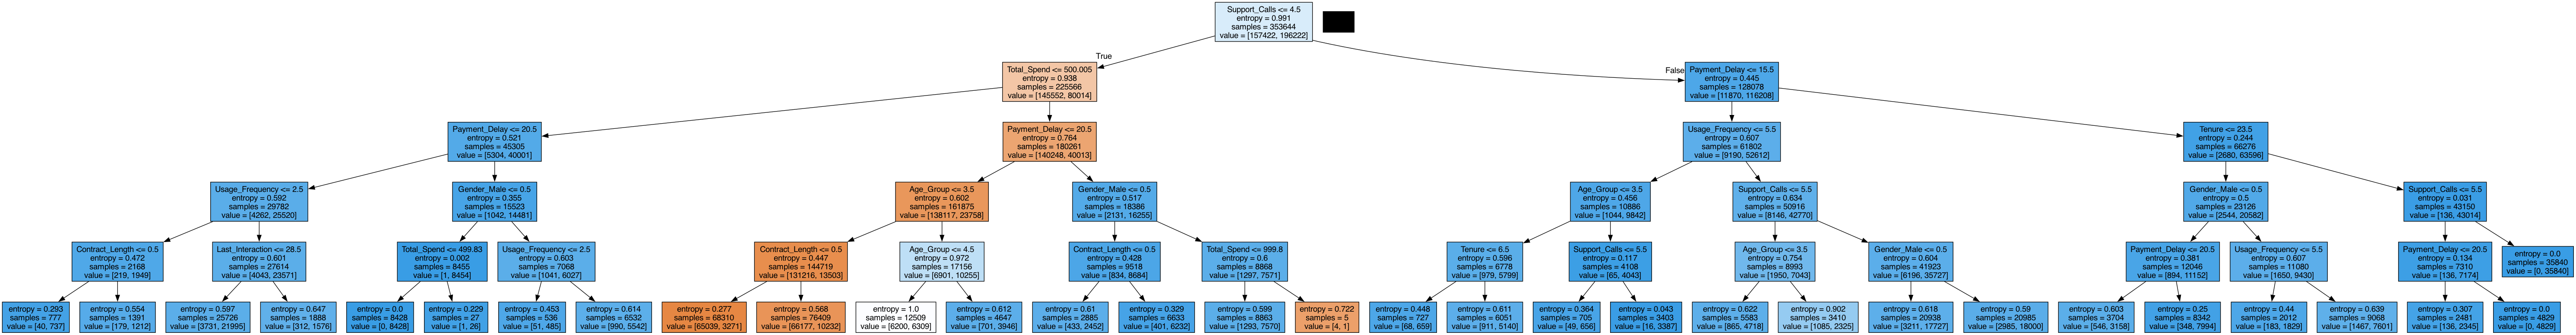

In [9]:
features = list(df2.drop('Churn', axis=1).columns)

dot_data = StringIO()
export_graphviz(model_dt, out_file=dot_data, feature_names=features, filled=True)
graph = pydot.graph_from_dot_data(dot_data.getvalue())
Image(graph[0].create_png())


# Random Forest

In [10]:
model_rf = RandomForestClassifier(n_estimators=50, random_state=101)
model_rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=50, random_state=101)

Feature ranking:


<Axes: title={'center': 'Feature importances_Random Forest'}, xlabel='Total Reduction of Criterion', ylabel='Feature'>

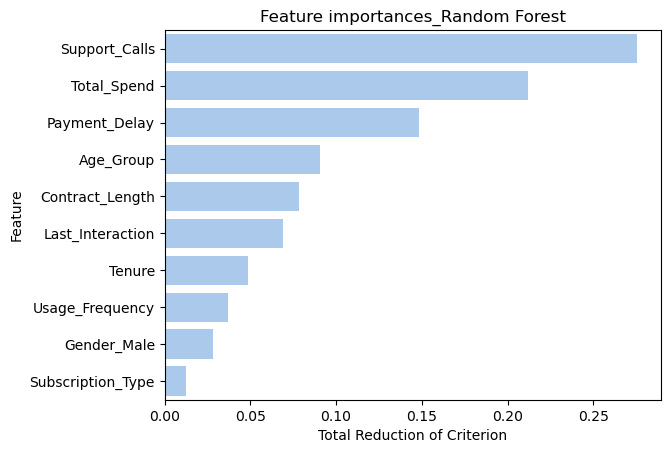

In [11]:
importances = model_rf.feature_importances_
indices = np.argsort(importances)[::-1]

print("Feature ranking:")

feature_names = X_train.columns 
fi = pd.DataFrame([feature_names[indices[0:10]], importances[indices][0:10]])
fi = fi.T
fi.columns = ['Feature', 'Total Reduction of Criterion']

plt.figure()
plt.title("Feature importances_Random Forest")
sns.set_color_codes("pastel")
sns.barplot(x="Total Reduction of Criterion", y="Feature", data=fi, color="b")

In [12]:
y_pred = model_rf.predict(X_test)

confusion_matrix_results = confusion_matrix(y_test, y_pred)
print('confusion matrix: \n', confusion_matrix_results)
display_metrics('Random Forest', y_pred, y_test)

confusion matrix: 
 [[57663  9629]
 [ 1412 82858]]
______________________________________________
Model: Random Forest
Accuracy: 0.927151924624906
Precision: 0.89588807075589
Recall: 0.983244333689332
F1-score: 0.9375357128713432
AUC: 0.9200757720280459
______________________________________________



# XGBoost

In [13]:
model_xgb = XGBClassifier()
model_xgb.fit(X_train, np.ravel(y_train))

y_pred = model_xgb.predict(X_test)

confusion_matrix_results = confusion_matrix(y_test, y_pred)
print('confusion matrix: \n', confusion_matrix_results)
display_metrics('XGBoost', y_pred, y_test)

confusion matrix: 
 [[57912  9380]
 [ 1818 82452]]
______________________________________________
Model: XGBoost
Accuracy: 0.9261160449189111
Precision: 0.897856956180852
Recall: 0.9784264862940548
F1-score: 0.9364118522220077
AUC: 0.9195169939643608
______________________________________________



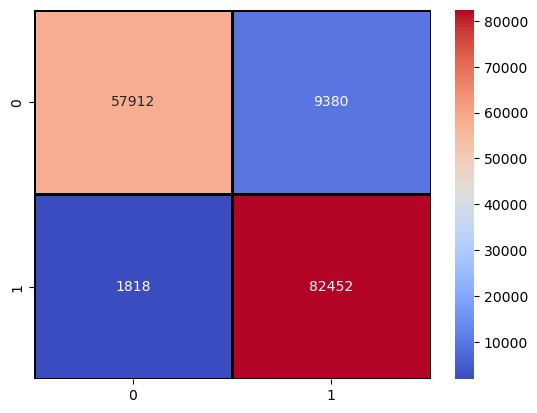

In [14]:
sns.heatmap(confusion_matrix(y_test, y_pred),cmap='coolwarm', linewidths=1, linecolor='black', annot=True, fmt='d')
plt.show()

# Cluster

In [15]:
df3 = df2[['Usage_Frequency','Support_Calls','Tenure','Payment_Delay','Total_Spend']]
df3

,Usage_Frequency,Support_Calls,Tenure,Payment_Delay,Total_Spend
0,14.0,5.0,39.0,18.0,932.0
1,1.0,10.0,49.0,8.0,557.0
2,4.0,6.0,14.0,18.0,185.0
3,21.0,7.0,38.0,7.0,396.0
4,20.0,5.0,32.0,8.0,617.0
...,...,...,...,...,...
505201,12.0,6.0,33.0,21.0,947.0
505202,1.0,5.0,6.0,22.0,923.0
505203,14.0,8.0,39.0,30.0,327.0
505204,19.0,7.0,18.0,22.0,540.0


/Users/oanh_nn/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/oanh_nn/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/oanh_nn/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/oanh_nn/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will chang

Text(0, 0.5, 'Within-Cluster Sum of Errors')

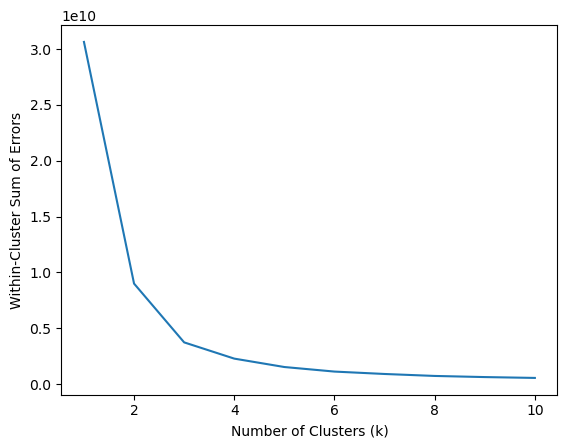

In [16]:
max_K = 10

k = np.arange(1, max_K+1)
errors = []

for i in range(1,max_K+1):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(df3)
    errors.append(kmeans.inertia_)
    
results = pd.DataFrame({'k': k, 'errors': errors})

plt.plot('k', 'errors', data=results)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Errors')

In [17]:
kmeans = KMeans(n_clusters=3, random_state=100, max_iter=100) 
X = df3
kmeans.fit(X)

/Users/oanh_nn/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(max_iter=100, n_clusters=3, random_state=100)

In [18]:
print(kmeans.labels_)
pd.DataFrame(kmeans.labels_).value_counts()

[0 1 2 ... 2 1 1]


0    195172
1    190063
2    119971
dtype: int64

In [19]:
df3['cluster'] = kmeans.labels_
df3

/var/folders/cy/qlmh8fjx6sn5lmvhq35rdtnr0000gn/T/ipykernel_8900/800974211.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['cluster'] = kmeans.labels_


,Usage_Frequency,Support_Calls,Tenure,Payment_Delay,Total_Spend,cluster
0,14.0,5.0,39.0,18.0,932.0,0
1,1.0,10.0,49.0,8.0,557.0,1
2,4.0,6.0,14.0,18.0,185.0,2
3,21.0,7.0,38.0,7.0,396.0,2
4,20.0,5.0,32.0,8.0,617.0,1
...,...,...,...,...,...,...
505201,12.0,6.0,33.0,21.0,947.0,0
505202,1.0,5.0,6.0,22.0,923.0,0
505203,14.0,8.0,39.0,30.0,327.0,2
505204,19.0,7.0,18.0,22.0,540.0,1


/var/folders/cy/qlmh8fjx6sn5lmvhq35rdtnr0000gn/T/ipykernel_8900/1401548573.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  median = df3.groupby('cluster')['Usage_Frequency','Support_Calls','Tenure','Payment_Delay','Total_Spend'].mean()


Text(0.5, 1.0, 'Heat map of Median in each cluster')

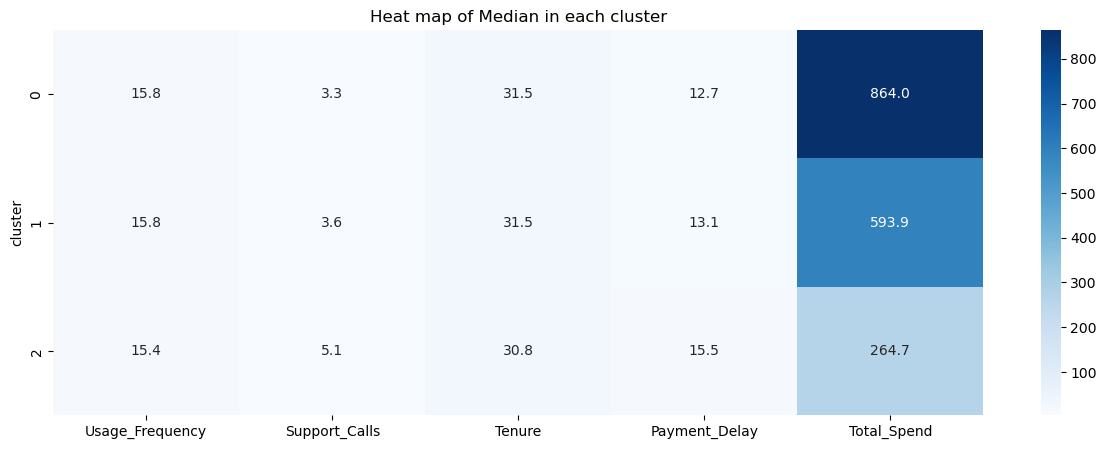

In [20]:
median = df3.groupby('cluster')['Usage_Frequency','Support_Calls','Tenure','Payment_Delay','Total_Spend'].mean()
fig = plt.figure(figsize = (15,5))
sns.heatmap(data = median , cmap = 'Blues' , annot = True, fmt = ".1f" )
plt.title('Heat map of Median in each cluster')